# DOTA 2 Surrogate 

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import glob
import matplotlib.pyplot as plt
from joblib import dump, load

## Import random games logs

In [2]:
files = glob.glob("games_data/*")
size = []
for f in files:
    print("%d / %d" %(len(size), len(files)), end='\r')
    df = pd.read_csv(f, index_col=0)
    size.append(len(df))
size = np.array(size)

## File size stats

860560 steps
Mean: 6776.062992125984 
Std: 3778.363441391602
Min: 122 
Max: 13235


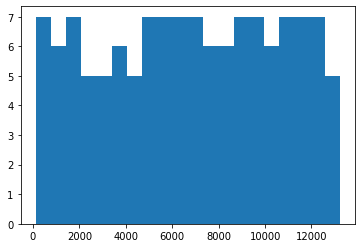

In [3]:
print("%d steps" %size.sum())
print("Mean:", size.mean(), "\nStd:", size.std())
print("Min:", size.min(), "\nMax:", size.max())
plt.hist(size, bins=20);

## Actions as vectors
One-hot encoding of actions, encoding movement on 2 features (North/South and East/West).

In [229]:
def action_to_vect(action):
    l = np.zeros(30)
    l[action]=1
    north = l[[1, 2, 8]].sum(axis=0) - l[[4, 5, 6]].sum(axis=0)
    east  = l[[2, 3, 4]].sum(axis=0) - l[[6, 7, 8]].sum(axis=0)
    vect = np.concatenate([[north, east], l[9:]])
    return vect

In [244]:
def actions_to_vect(a):
    if type(a)==pd.Series:
        columns = ['North', "East", 
           'Top Bounty Rune', 'Bot Bounty Rune', 'Top Powerup  Rune', 'Bot Powerup  Rune',
                    "Attack Enemy Hero", "Attack Enemy Tower", 
                    "Attack Creep 0 (Nearest Enemy)", "Attack Creep 1", "Attack Creep 2", "Attack Creep 3", "Attack Creep 4",
                    "Attack Creep 5 (Nearest Friendly)", "Attack Creep 6", "Attack Creep 7", "Attack Creep 8", "Attack Creep 9",
                    "Cast Shadowraze 1 (Short)", "Cast Shadowraze 2 (Medium)", "Cast Shadowraze 3 (Long)",
                    "Cast Requiem of Souls (Ultimate)", "Use Healing Salve"
                  ]
        df = pd.DataFrame(list(a.apply(action_to_vect)), columns=columns)
        return df
    
    else:
        return action_to_vect(a)

## Get the (state + action, next_state) tuples
And scaling the state values

In [5]:
def transform(df, scaler=None):
    action = actions_to_vect(df['action'])
    state = df.drop(columns=['action'])
    
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(state)
    state = pd.DataFrame(scaler.transform(state))
#     print(state.head())
    
    X = pd.concat([state, action], axis=1, ignore_index=False)
    X = X.drop(index=len(X)-1)
    
    y = state.drop(index=0)
    return X, y, scaler


## Data transform pipeline
From file names to transformed unified dataset.

In [22]:
def data_pipeline(files):
    scaler = None
    X_list, y_list = [], []
    for f in files:
        df = pd.read_csv(f, index_col=0)
        X, y, scaler = transform(df, scaler=scaler)
        X_list.append(X)
        y_list.append(y)
        print('%s   \tImported: %d lines' %(f, len(df)), end='\n')
    X = pd.concat(X_list, axis=0, ignore_index=True)
    y = pd.concat(y_list, axis=0, ignore_index=True)
    return X, y, scaler

In [250]:
data_pipeline(files[:1])[0]

games_data\rd_12065.csv   	Imported: 10011 lines


,0,1,2,3,4,5,6,7,8,9,...,Attack Creep 5 (Nearest Friendly),Attack Creep 6,Attack Creep 7,Attack Creep 8,Attack Creep 9,Cast Shadowraze 1 (Short),Cast Shadowraze 2 (Medium),Cast Shadowraze 3 (Long),Cast Requiem of Souls (Ultimate),Use Healing Salve
0,0.0,-0.632562,0.006237,-2.748360,1.753613,0.976623,-2.874193,2.504940,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.632562,0.111373,-2.097021,1.836083,1.083117,-2.188701,2.627005,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.632562,0.111373,-2.097021,1.836083,1.083117,-2.188701,2.627005,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.632562,0.321645,-0.794345,2.001023,1.296106,-0.817716,2.871136,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.632562,0.321645,-0.794345,-0.248157,1.296106,-0.817716,-0.353297,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-0.632562,0.321645,-0.794345,-0.248157,1.296106,-0.817716,-0.353297,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,-0.632562,0.321645,-0.794345,-0.248157,1.296106,-0.817716,-0.353297,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,-0.632562,0.321645,-0.794345,-0.248157,1.296106,-0.817716,-0.353297,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,-0.632562,0.321645,-0.794345,-0.248157,1.296106,-0.817716,-0.353297,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,-0.632562,0.321645,-0.794345,-0.248157,1.296106,-0.817716,-0.353297,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def save_data(X, y, scaler):
    print('Saving...')
    X.to_csv('full_X.csv')
    print('X saved')
    y.to_csv('full_y.csv')
    print('y saved')
    dump(scaler, 'scaler.joblib') 
    print('scaler saved')
    
def load_data():
    print('Loading...')
    X = pd.read_csv('full_X.csv', index_col=0)
    print('X loaded')
    y = pd.read_csv('full_y.csv', index_col=0)
    print('y loaded')
    scaler = load('scaler.joblib') 
    print('scaler loaded')
    return X, y, scaler

In [17]:
dump(scaler, 'scaler.joblib') 

['scaler.joblib']

In [18]:
scaler_load = load('scaler.joblib') 

## Surrogate model
### Model test

In [117]:
# Utils
import time
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_squared_log_error, r2_score

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor



In [120]:
def train_model(model, X, y):
    """
    model can be 1 estimator or a list of estimators
    """
    print("X shape:", X.shape, "\ny shape:", y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    print("Train_test shapes", X_train.shape, X_test.shape, y_train.shape, y_test.shape, '\n')
    
    if type(model)!=list:
        model = [model]
        
    for m in model:
        print("-- Training %s --\n" %str(type(m)).split('.')[-1][:-2])
        t0 = time.time()
        print('Training...', end='\r')
        m.fit(X_train, y_train)
        print('Training time %ds\n' %int(time.time()-t0))
        y_pred = m.predict(X_test)

        print("Scores:")
        score_expl_var = explained_variance_score(y_test, y_pred)
        print("Explained variance: \t{:4.4f} (Best: 1.0)".format(score_expl_var))
        
        try:
            score_mse = mean_squared_error(y_test, y_pred)
            print("Mean Square Error: \t{:4.4f} (Best: 0.0)".format(score_mse))
        except:
            pass
        try:
            score_msle = mean_squared_log_error(y_test, y_pred)
            print("Mean Square Log Error: \t{:4.4f} (Best: 0.0)".format(score_msle))
        except:
            pass
        try:
            score_r2 = r2_score(y_test, y_pred)
            print("R2 score: \t\t{:4.4f} (Best: 1.0)\n\n".format(score_r2))
        except:
            pass
    return model

In [122]:
models = [RandomForestRegressor(), MultiOutputRegressor(Ridge(random_state=0))]

train_model(models, X.head(2000), y.head(2000))

X shape: (2000, 333) 
y shape: (2000, 310)
Train_test shapes (1500, 333) (500, 333) (1500, 310) (500, 310) 

-- Training RandomForestRegressor --

Training time 9s

Scores:
Explained variance: 	0.7905 (Best: 1.0)
Mean Square Error: 	0.2092 (Best: 0.0)
R2 score: 		0.7803 (Best: 1.0)


-- Training MultiOutputRegressor --

Training time 5s

Scores:
Explained variance: 	0.8196 (Best: 1.0)
Mean Square Error: 	0.1814 (Best: 0.0)
R2 score: 		0.8095 (Best: 1.0)




[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False),
 MultiOutputRegressor(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                      max_iter=None, normalize=False,
                                      random_state=0, solver='auto', tol=0.001),
                      n_jobs=None)]

In [330]:
class DOTA2_surrogate:
    def __init__(self, model, scaler):
        self.state = None
        self.agent = None
        self.model = model
        self.scaler = scaler
        self.step_nb=0
        
    def reset(self):
        # Reset env
        self.state = np.array(pd.read_csv("Init_state.csv", index_col=0, names=['init'])['init'])
        self.step_nb=0
        print("Env Reset")
        return self.state
    
    def step(self, action):
        if self.state is None:
            self.reset()
        
        state_scaled = self.scaler.transform(self.state.reshape(1, -1))
        
        action_vect = actions_to_vect(action).reshape(1, -1)
        
        x = np.concatenate([state_scaled, action_vect], axis=1)
        
        y = self.model.predict(x)
        self.state = self.scaler.inverse_transform(y)[0]
        self.step_nb += 1
        return self.state
        
    def render(self, mode='human'):
        t = self.state[56]
        x, y = self.state[26:28]
        print("%d > Time: %d | (%d , %d)" %(self.step_nb, t, x, y))
        return self.state

Env Reset


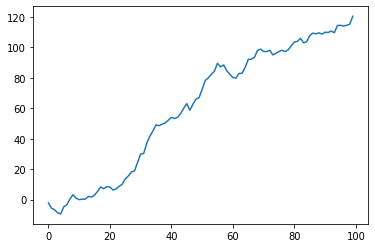

Text(0, 0.5, 'Steps')

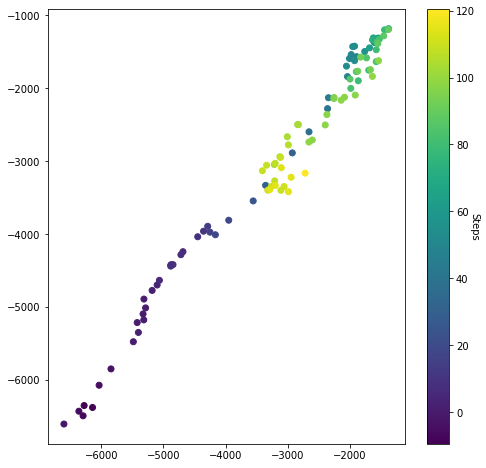

In [336]:
import random as rd
sur = DOTA2_surrogate(models[1], scaler)
state = sur.reset()
# sur.render()
t = []
pos_x, pos_y = [], []
for i in range(100):
    a = rd.randint(0, 29)
    state = sur.step(a)
    t.append(state[56])
    pos_x.append(state[26])
    pos_y.append(state[27])
#     sur.render()
    
plt.plot(t)
plt.show()



Text(0, 0.5, 'Game Steps')

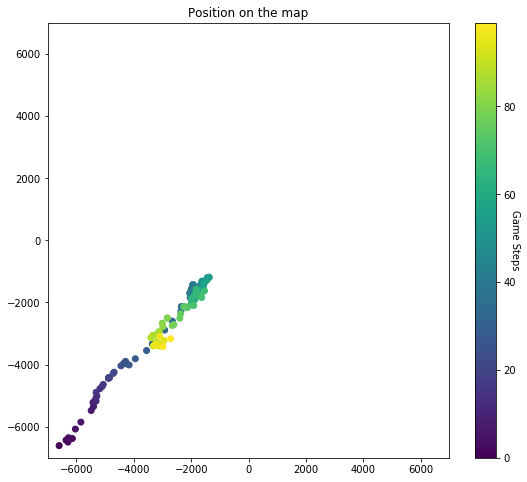

In [346]:
plt.figure(figsize=(9, 8))
sc = plt.scatter(pos_x, pos_y, c=range(len(pos_x)))
plt.xlim(-7000, 7000)
plt.ylim(-7000, 7000)
plt.title("Position on the map")
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Game Steps', rotation=270)